In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [3]:
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)
df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')


# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

<AxesSubplot:>

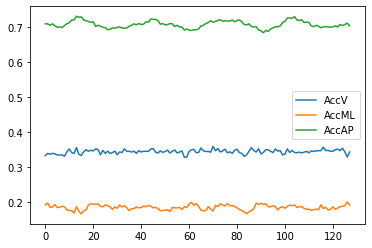

In [4]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [5]:
x_win = []
y_win = []

x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%256,128):
    x_win.append(x[i:i+256])
    y_win.append(y[i:i+256])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [6]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

In [7]:
x_win_aug = []
y_win_s2l_aug = []
for i in range(len(y_win_s2l)):
    x_win_aug.append(x_win[i])
    y_win_s2l_aug.append(y_win_s2l[i])
    
    if y_win_s2l[i,0]==1:
        x_win_aug.append(x_win[i])
        y_win_s2l_aug.append(y_win_s2l[i])
x_win_aug = np.asarray(x_win_aug,dtype = np.float32)
y_win_s2l_aug = np.asarray(y_win_s2l_aug,dtype = int)

In [8]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [9]:
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy",factor=0.5,patience=8,)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
# checkpointer = ModelCheckpoint_tweaked(filepath='best.hdf5', verbose=0, save_best_only=True)
# csv_logger = tf.keras.callbacks.CSVLogger("model_history_log.csv", append=True)

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(x_win_aug, y_win_s2l_aug, test_size=0.10)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50)

# model_aug = Sequential([
#     LSTM(100, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
#     Dropout(0.2),
#     Dense(2, activation = 'softmax') 
# ])

# model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),#, clipvalue=0.5),
#                 loss='categorical_crossentropy', 
#                 metrics=['accuracy'],
                
#                 )

# model_aug.summary()
# tf.config.list_physical_devices('GPU')

In [11]:
# model_aug.fit(x_train, y_train, batch_size = 256, epochs = 1000, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

In [12]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        print(' - lr:',model.optimizer._decayed_lr(tf.float32).numpy())

In [19]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
k = 0
rlr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001,decay_steps=409,decay_rate=0.96,staircase=True)

In [20]:
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_s2l_aug[train], test_size=0.10)

    model = Sequential([
        LSTM(100, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
        Dropout(0.2),

        Dense(2, activation = 'softmax') 
    ])
    
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = rlr),#, clipvalue=0.5),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=25)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

    model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback()],validation_data=(x_val,y_val))
    model = tf.keras.models.load_model(f'best_{k}.hdf5')
    models.append(model)
    evals.append(model.evaluate(x_win_aug[test],y_win_s2l_aug[test]))
    
    k+=1

Epoch 1/500
  6/204 [..............................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5182WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0291s vs `on_train_batch_end` time: 0.0389s). Check your callbacks.


204/204 [==============================] - 15s 66ms/step - loss: 0.5954 - accuracy: 0.6711 - val_loss: 0.5983 - val_accuracy: 0.6700
Epoch 2/500
204/204 [==============================] - 12s 60ms/step - loss: 0.6245 - accuracy: 0.6378 - val_loss: 0.6213 - val_accuracy: 0.6640
Epoch 3/500
204/204 [==============================] - 12s 60ms/step - loss: 0.6416 - accuracy: 0.6456 - val_loss: 0.6609 - val_accuracy: 0.5590
Epoch 4/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6418 - accuracy: 0.6252 - val_loss: 0.6000 - val_accuracy: 0.6887
Epoch 5/500
204/204 [==============================] - 12s 60ms/step - loss: 0.6221 - accuracy: 0.6514 - val_loss: 0.5990 - val_accuracy: 0.6752
Epoch 6/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6325 - accuracy: 0.6143 - val_loss: 0.6328 - val_accuracy: 0.6340
Epoch 7/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6353 - accuracy: 0.6367 - val_loss: 0.6051 - val_accuracy: 0.64

204/204 [==============================] - 14s 65ms/step - loss: 0.6065 - accuracy: 0.6602 - val_loss: 0.6341 - val_accuracy: 0.6403
Epoch 2/500
204/204 [==============================] - 13s 63ms/step - loss: 0.5993 - accuracy: 0.6741 - val_loss: 0.6336 - val_accuracy: 0.6701
Epoch 3/500
204/204 [==============================] - 13s 63ms/step - loss: 0.6447 - accuracy: 0.6140 - val_loss: 0.6173 - val_accuracy: 0.6476
Epoch 4/500
204/204 [==============================] - 13s 63ms/step - loss: 0.6338 - accuracy: 0.6205 - val_loss: 0.5771 - val_accuracy: 0.6915
Epoch 5/500
204/204 [==============================] - 13s 63ms/step - loss: 0.6285 - accuracy: 0.6191 - val_loss: 0.6488 - val_accuracy: 0.5776
Epoch 6/500
204/204 [==============================] - 13s 63ms/step - loss: 0.6732 - accuracy: 0.5688 - val_loss: 0.6524 - val_accuracy: 0.6104
Epoch 7/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6564 - accuracy: 0.5811 - val_loss: 0.6269 - val_accuracy: 0.64

204/204 [==============================] - 16s 72ms/step - loss: 0.6217 - accuracy: 0.6303 - val_loss: 0.6030 - val_accuracy: 0.6440
Epoch 2/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6322 - accuracy: 0.6507 - val_loss: 0.6105 - val_accuracy: 0.6735
Epoch 3/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6756 - accuracy: 0.5967 - val_loss: 0.7428 - val_accuracy: 0.5023
Epoch 4/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6929 - accuracy: 0.5670 - val_loss: 0.6414 - val_accuracy: 0.6632
Epoch 5/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6538 - accuracy: 0.6264 - val_loss: 0.6713 - val_accuracy: 0.5845
Epoch 6/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6148 - accuracy: 0.6597 - val_loss: 0.6420 - val_accuracy: 0.6785
Epoch 7/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6528 - accuracy: 0.6166 - val_loss: 0.6563 - val_accuracy: 0.54

204/204 [==============================] - 16s 72ms/step - loss: 0.6606 - accuracy: 0.5993 - val_loss: 0.6367 - val_accuracy: 0.6348
Epoch 2/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6536 - accuracy: 0.6034 - val_loss: 0.6284 - val_accuracy: 0.5750
Epoch 3/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6659 - accuracy: 0.6205 - val_loss: 0.6707 - val_accuracy: 0.5974
Epoch 4/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6430 - accuracy: 0.6308 - val_loss: 0.6370 - val_accuracy: 0.6491
Epoch 5/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6954 - accuracy: 0.5504 - val_loss: 0.6943 - val_accuracy: 0.5616
Epoch 6/500
204/204 [==============================] - 14s 71ms/step - loss: 0.6743 - accuracy: 0.5929 - val_loss: 0.6032 - val_accuracy: 0.6858
Epoch 7/500
204/204 [==============================] - 15s 71ms/step - loss: 0.6380 - accuracy: 0.6349 - val_loss: 0.6677 - val_accuracy: 0.60

204/204 [==============================] - 16s 72ms/step - loss: 0.6213 - accuracy: 0.6605 - val_loss: 0.6783 - val_accuracy: 0.6509
Epoch 2/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6390 - accuracy: 0.6628 - val_loss: 0.6285 - val_accuracy: 0.6969
Epoch 3/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6132 - accuracy: 0.6858 - val_loss: 0.5675 - val_accuracy: 0.7266
Epoch 4/500
204/204 [==============================] - 14s 70ms/step - loss: 0.5879 - accuracy: 0.7059 - val_loss: 0.7097 - val_accuracy: 0.5732
Epoch 5/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6640 - accuracy: 0.5767 - val_loss: 0.6662 - val_accuracy: 0.5661
Epoch 6/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6653 - accuracy: 0.5474 - val_loss: 0.6595 - val_accuracy: 0.5824
Epoch 7/500
204/204 [==============================] - 14s 70ms/step - loss: 0.6504 - accuracy: 0.5724 - val_loss: 0.6504 - val_accuracy: 0.59

In [21]:
import tensorflow_addons as tfa
# x_win_aug[test],y_win_s2l_aug[test]
f1 = []
recalls = []
precisions = []
k = 0
kfold = KFold(n_splits=5, shuffle=False)
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    metric = tfa.metrics.F1Score(num_classes=2,threshold=0.5)

    y_true = y_win_s2l_aug[test]
    y_pred = models[k].predict(x_win_aug[test])

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    recalls.append(recall.result().numpy())
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    precisions.append(precision.result().numpy())
    k+=1
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

452/452 [==============================] - 4s 9ms/step


In [22]:
import pickle
file1 = open('evaluations', 'wb')
file2 = open('models', 'wb')
file3 = open('scores', 'wb')
pickle.dump(evals, file1)
pickle.dump(models, file2)
pickle.dump([f1,recalls,precisions], file3)
file1.close()
file2.close()
file3.close()

INFO:tensorflow:Assets written to: ram://9ffb41de-47a4-4e92-bac3-8c3a8f8c3aa2/assets


INFO:tensorflow:Assets written to: ram://9ffb41de-47a4-4e92-bac3-8c3a8f8c3aa2/assets


INFO:tensorflow:Assets written to: ram://4eded8e5-556c-4687-891a-ff34e65e6787/assets


INFO:tensorflow:Assets written to: ram://4eded8e5-556c-4687-891a-ff34e65e6787/assets


INFO:tensorflow:Assets written to: ram://ae5d718b-55ed-48ea-be38-a51d5d1d7e3f/assets


INFO:tensorflow:Assets written to: ram://ae5d718b-55ed-48ea-be38-a51d5d1d7e3f/assets


INFO:tensorflow:Assets written to: ram://0989906c-2d30-45a3-a8f4-dc0ebe29efac/assets


INFO:tensorflow:Assets written to: ram://0989906c-2d30-45a3-a8f4-dc0ebe29efac/assets


INFO:tensorflow:Assets written to: ram://56ec2836-bc73-4ea3-97fc-3df3e32ddee7/assets


INFO:tensorflow:Assets written to: ram://56ec2836-bc73-4ea3-97fc-3df3e32ddee7/assets
